In [ ]:
!pip install d2l==1.0.0-beta0


Vào năm 2014, bài báo khoa học [Szegedy et al., 2015] đã giành chiến thắng ở cuộc thi ImageNet, bằng việc đề xuất một cấu trúc kết hợp những điểm mạnh của mô hình NiN và mô hình chứa các khối lặp lại. Bài báo này tập trung giải quyết câu hỏi: kích thước nào của bộ lọc tích chập là tốt nhất. Suy cho cùng, các mạng phổ biến trước đây chọn kích thước bộ lọc từ nhỏ như  1×1
  tới lớn như  11×11
 . Một góc nhìn sâu sắc trong bài báo này là đôi khi việc kết hợp các bộ lọc có kích thước khác nhau có thể sẽ hiệu quả. Trong phần này, chúng tôi sẽ giới thiệu mô hình GoogLeNet, bằng việc trình bày một phiên bản đơn giản hơn một chút so với phiên bản gốc—bỏ qua một số tính năng đặc biệt trước đây được thêm vào nhằm ổn định quá trình huấn luyện nhưng hiện nay không cần thiết nữa do đã có các thuật toán huấn luyện tốt hơn.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 8.4.1. Khối Inception

Khối tích chập cơ bản trong mô hình GoogLeNet được gọi là Inception, nhiều khả năng được đặt tên dựa theo câu nói “Chúng ta cần đi sâu hơn” (“We Need To Go Deeper”) trong bộ phim Inception, sau này đã tạo ra một trào lưu lan rộng trên internet.
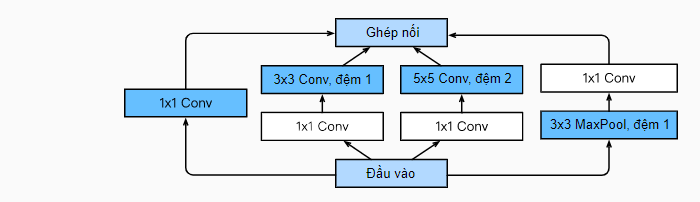

Như mô tả ở hình trên, khối inception bao gồm bốn nhánh song song với nhau. Ba nhánh đầu sử dụng các tầng tích chập với kích thước cửa sổ trượt lần lượt là $1×1$, $3×3$, và $5×5$ để trích xuất thông tin từ các vùng không gian có kích thước khác nhau. Hai nhánh giữa thực hiện phép tích chập $1×1$ trên dữ liệu đầu vào để giảm số kênh đầu vào, từ đó giảm độ phức tạp của mô hình. Nhánh thứ tư sử dụng một tầng gộp cực đại kích thước  $3×3$
 , theo sau là một tầng tích chập  $1×1$ để thay đổi số lượng kênh. Cả bốn nhánh sử dụng phần đệm phù hợp để đầu vào và đầu ra của khối có cùng chiều cao và chiều rộng. Cuối cùng, các đầu ra của mỗi nhánh sẽ được nối lại theo chiều kênh để tạo thành đầu ra của cả khối. Các tham số thường được tinh chỉnh của khối Inception là số lượng kênh đầu ra mỗi tầng.

In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

Để hiểu trực quan tại sao mạng này hoạt động tốt, hãy cùng tìm hiểu sự kết hợp của các bộ lọc. Chúng khám phá hình ảnh trên các vùng có kích thước khác nhau. Tức là những chi tiết ở những mức độ khác nhau sẽ được nhận diện một cách hiệu quả bằng các bộ lọc khác nhau. Đồng thời, chúng ta có thể phân bổ số lượng tham số khác nhau cho những vùng có phạm vi khác nhau (ví dụ: nhiều tham số hơn cho vùng phạm vi nhỏ nhưng không bỏ qua hoàn toàn vùng phạm vi lớn).

# 8.4.2. Mô hình GoogLeNet

Như trình bày ở hình dưới, mô hình GoogLeNet sử dụng tổng cộng 9 khối inception và tầng gộp trung bình toàn cục xếp chồng lên nhau. Phép gộp cực đại giữa các khối inception có tác dụng làm giảm kích thước chiều. Phần đầu tiên của GoogleNet giống AlexNet và LeNet, có các khối xếp chồng lên nhau kế thừa từ thiết kế của VGG và phép gộp trung bình toàn cục giúp tránh phải sử dụng nhiều tầng kết nối đầy đủ liên tiếp ở cuối. Cấu trúc của mô hình được mô tả như dưới đây.

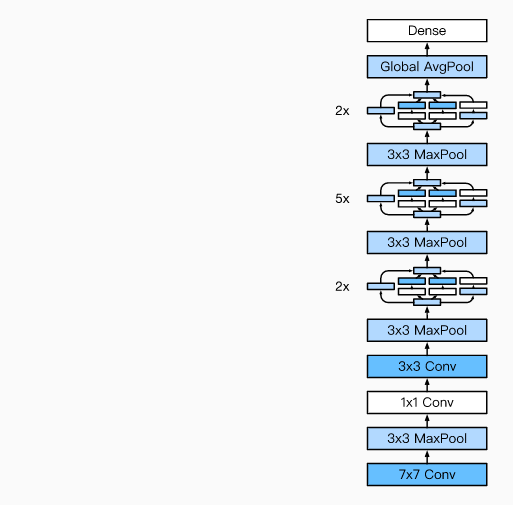

Giờ đây, chúng ta có thể triển khai từng phần của GoogLeNet. Hãy bắt đầu với thân cây. Mô-đun đầu tiên sử dụng 64 kênh $7\times 7$ lớp tích chập.

In [ ]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Thành phần thứ hai sử dụng hai tầng tích chập: tầng đầu tiên có đầu ra 64 kênh và cửa sổ $1×1$, tiếp theo là một tầng có cửa sổ $3×3$ và số kênh đầu ra gấp ba lần số kênh đầu vào. Phần này giống với nhánh thứ hai trong khối Inception.

In [ ]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Thành phần thứ ba kết nối hai khối Inception hoàn chỉnh một cách tuần tự. Số kênh đầu ra của khối Inception đầu tiên là $64+128+32+32=256$, và tỉ lệ số kênh của bốn nhánh là $64:128:32:32=2:4:1:1$. Nhánh thứ hai và nhánh thứ ba của khối này ở tầng tích chập đầu tiên làm giảm số lượng kênh đầu vào với tỉ lệ lần lượt là $96/192=1/2$ và  $16/192=1/12$, sau đó kết nối với tầng tích chập thứ hai. Số kênh đầu ra của khối Inception thứ hai tăng lên tới $128+192+96+64=480$, và tỉ lệ số kênh của bốn nhánh là  $128:192:96:64=4:6:3:2$. Tầng tích chập đầu tiên của nhánh thứ hai và thứ ba làm giảm số kênh đầu vào với tỉ lệ lần lượt là $128/256=1/2$
  và  $32/256=1/8$.

In [ ]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Thành phần thứ tư phức tạp hơn. Thành phần này kết nối năm khối Inception có số kênh đầu ra lần lượt là $192+208+48+64=512$, $160+224+64+64=512$, $128+256+64+64=512$, $112+288+64+64=528$, và $256+320+128+128=832$. Số kênh được gán cho các nhánh tương tự như trong mô đun thứ ba: nhánh thứ hai với tầng tích chập $3×3$ sẽ cho đầu ra với số kênh lớn nhất, tiếp theo là nhánh thứ nhất với tầng tích chập $1×1$, nhánh thứ ba với tầng tích chập $5×5$, cuối cùng là nhánh thứ tư với tầng gộp cực đại $3×3$. Đầu tiên, nhánh thứ hai và thứ ba sẽ làm giảm số lượng kênh theo một tỷ lệ nhất định. Tỷ lệ này sẽ hơi khác nhau trong các khối Inception khác nhau.

In [ ]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Thành phần thứ năm có hai khối Inception với số kênh đầu ra lần lượt là $256+320+128+128=832$ và  $384+384+128+128=1024$. Số lượng kênh được gán cho mỗi nhánh tương tự như trong mô-đun thứ ba và thứ tư, chỉ khác nhau ở giá trị cụ thể. Lưu ý rằng thành phần thứ năm được theo sau bởi tầng đầu ra. Thành phần này sử dụng tầng gộp trung bình toàn cục để giảm chiều cao và chiều rộng của mỗi kênh xuống còn 1, giống như trong mô hình NiN. Cuối cùng, chúng ta biến đổi đầu ra thành một mảng hai chiều, đưa vào một tầng kết nối đầy đủ với số đầu ra bằng số lượng lớp của nhãn.

In [ ]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

Bây giờ chúng ta đã xác định tất cả các khối b1thông qua b5, vấn đề chỉ là lắp ráp tất cả chúng thành một mạng đầy đủ.

In [ ]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

Mô hình GoogLeNet khá phức tạp về mặt tính toán, nên không dễ để thay đổi số lượng kênh giống như VGG. Để có thời gian huấn luyện hợp lý trên bộ dữ liệu Fashion-MNIST, chúng ta cần giảm chiều cao và chiều rộng của đầu vào từ 224 xuống 96. Điều này làm đơn giản hoá việc tính toán. Sự thay đổi ở kích thước đầu ra giữa các mô đun khác nhau được minh hoạ như dưới đây.

In [ ]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


# 8.3.4. Training.

Vẫn như trước, chúng ta sử dụng tập dữ liệu Fashion-MNIST để huấn luyện mô hình. Chúng ta chuyển đổi độ phân giải hình ảnh thành $96×96$ điểm ảnh trước khi bắt đầu quá trình huấn luyện.

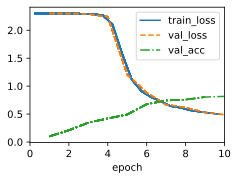

In [ ]:
data = d2l.FashionMNIST(batch_size = 128, resize = (96,96))
model = GoogleNet(lr = 0.01)
trainer = d2l.Trainer(max_epochs = 10, num_gpus = 1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model,data)